In [4]:
import pandas as pd #Dataframe, Series
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc

from sklearn.metrics import accuracy_score

import spotipy
import spotipy.util as util
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 

%matplotlib inline

### Login

In [40]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

client_id = '164fe11263da4ce8b39cb03311385ce6'
client_secret = '448a0146206e4b718e4bcc0865efcd29'
redirect_uri='http://localhost:8080/callback'
username = '5865b9eadfc54092'
scope = "user-library-read","playlist-modify-private"


#Credentials to access the Spotify Music Data
from spotipy.oauth2 import SpotifyOAuth
import spotipy

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id,
                                               client_secret,
                                               redirect_uri,
                                               scope = 'user-library-read playlist-read-private'))

### Input Data into Model

- gathering good and bad playlists
- The method signature is sp.user_playlist('user', 'playlist_id')
- To do this go to your good and bad playlists and copy the links.
    - An example spotify link: https://open.spotify.com/user/1287242681/playlist/5OdH7PmotfAO7qDGxKdw3J
    - The user is the number after user/ and the playlist id is after the playlist/.

In [6]:
good_playlist = sp.user_playlist("baacf740f3a541f9", "49fIpD0ywwbKeJoN6OfmgW")
# https://open.spotify.com/playlist/49fIpD0ywwbKeJoN6OfmgW?si=ac7c01e1a19d4cf1
bad_playlist = sp.user_playlist("baacf740f3a541f9", "12w4Scq6FS8FMvKBtAh2S9")
# https://open.spotify.com/playlist/12w4Scq6FS8FMvKBtAh2S9?si=88fb8685585a4d97

In [7]:
#Get the good song id's out of the good playlists, need it for the audio features call.
good_tracks = good_playlist["tracks"]
good_songs = good_tracks["items"] 
while good_tracks['next']:
    good_tracks = sp.next(good_tracks)
    for item in good_tracks["items"]:
        good_songs.append(item)
good_ids = [] 
print(len(good_songs))
for i in range(len(good_songs)- 500):
    good_ids.append(good_songs[i]['track']['id'])
# good_tracks

799


In [8]:
#Now do the same thing for the bad playlist
bad_tracks = bad_playlist["tracks"]
bad_songs = bad_tracks["items"] 
while bad_tracks['next']:
    bad_tracks = sp.next(bad_tracks)
    for item in bad_tracks["items"]:
        bad_songs.append(item)
bad_ids = [] 
print(len(bad_songs))
for i in range(len(bad_songs)):
    bad_ids.append(bad_songs[i]['track']['id'])

281


In [9]:
#Here is where we get all of the audio_features for the tracks on the good and bad playlists.
features = []
inSavedTracks = []
j = 0
for i in range(0,len(good_ids),50):
    print(i)
    audio_features = sp.audio_features(good_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 1
j = 0
for i in range(0,len(bad_ids),50):
    audio_features = sp.audio_features(bad_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 0

0
50
100
150
200
250


In [10]:
trainingData = pd.DataFrame(features)
trainingData.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackPopularity,artistPopularity,target
0,0.829,0.512,6,-5.865,0,0.1870,0.49200,0.000000,0.120,0.638,...,audio_features,4XvcHTUfIlWfyJTRG0aqlo,spotify:track:4XvcHTUfIlWfyJTRG0aqlo,https://api.spotify.com/v1/tracks/4XvcHTUfIlWf...,https://api.spotify.com/v1/audio-analysis/4Xvc...,123987,4,83,75.0,1
1,0.526,0.606,5,-5.300,0,0.2590,0.15200,0.000002,0.194,0.492,...,audio_features,0vjeOZ3Ft5jvAi9SBFJm1j,spotify:track:0vjeOZ3Ft5jvAi9SBFJm1j,https://api.spotify.com/v1/tracks/0vjeOZ3Ft5jv...,https://api.spotify.com/v1/audio-analysis/0vje...,182667,4,89,88.0,1
2,0.878,0.714,8,-6.344,1,0.2390,0.05280,0.000008,0.143,0.636,...,audio_features,0JDsxnw0kjsXX1M6Vagzak,spotify:track:0JDsxnw0kjsXX1M6Vagzak,https://api.spotify.com/v1/tracks/0JDsxnw0kjsX...,https://api.spotify.com/v1/audio-analysis/0JDs...,195600,4,55,85.0,1
3,0.838,0.802,11,-3.639,0,0.0445,0.00592,0.003390,0.326,0.621,...,audio_features,23A29DEDxMZdwpl0ZRrMOk,spotify:track:23A29DEDxMZdwpl0ZRrMOk,https://api.spotify.com/v1/tracks/23A29DEDxMZd...,https://api.spotify.com/v1/audio-analysis/23A2...,137900,4,73,85.0,1
4,0.755,0.404,9,-6.404,0,0.0539,0.60600,0.000080,0.127,0.195,...,audio_features,1s9wSzybysJGkhRcgcgasN,spotify:track:1s9wSzybysJGkhRcgcgasN,https://api.spotify.com/v1/tracks/1s9wSzybysJG...,https://api.spotify.com/v1/audio-analysis/1s9w...,179424,4,57,62.0,1


In [11]:
train, test = train_test_split(trainingData, test_size = 0.15)
print("Training size: {}, Test size: {}".format(len(train),len(test)))

Training size: 493, Test size: 87


In [12]:
# Custom Color Palette for graphs
red_blue = ['#19B5FE', '#EF4836']
palette = sns.color_palette(red_blue)
sns.set_palette(palette)
sns.set_style('white')

In [13]:
pos_tempo = trainingData[trainingData['target'] == 1]['tempo']
neg_tempo = trainingData[trainingData['target'] == 0]['tempo']
pos_dance = trainingData[trainingData['target'] == 1]['danceability']
neg_dance = trainingData[trainingData['target'] == 0]['danceability']
pos_duration = trainingData[trainingData['target'] == 1]['duration_ms']
neg_duration = trainingData[trainingData['target'] == 0]['duration_ms']
pos_loudness = trainingData[trainingData['target'] == 1]['loudness']
neg_loudness = trainingData[trainingData['target'] == 0]['loudness']
pos_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
neg_speechiness = trainingData[trainingData['target'] == 0]['speechiness']
pos_valence = trainingData[trainingData['target'] == 1]['valence']
neg_valence = trainingData[trainingData['target'] == 0]['valence']
pos_energy = trainingData[trainingData['target'] == 1]['energy']
neg_energy = trainingData[trainingData['target'] == 0]['energy']
pos_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
neg_acousticness = trainingData[trainingData['target'] == 0]['acousticness']
pos_key = trainingData[trainingData['target'] == 1]['key']
neg_key = trainingData[trainingData['target'] == 0]['key']
pos_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
neg_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']
pos_popularity = trainingData[trainingData['target'] == 1]['trackPopularity']
neg_popularity = trainingData[trainingData['target'] == 0]['trackPopularity']

In [14]:
print(pos_tempo)


0       80.511
1      116.622
2      150.029
3      147.972
4       99.012
        ...   
294    157.157
295    100.021
296    135.096
297     82.011
298     83.913
Name: tempo, Length: 299, dtype: float64


In [15]:
print(neg_tempo)

299    115.966
300    124.955
301    128.054
302    128.019
303    119.986
        ...   
575    126.984
576    140.036
577    141.958
578    135.942
579    159.897
Name: tempo, Length: 281, dtype: float64


In [16]:
print(pos_popularity)
print(neg_popularity)

0      83
1      89
2      55
3      73
4      57
       ..
294    14
295    49
296     0
297    58
298    65
Name: trackPopularity, Length: 299, dtype: int64
299    83
300    89
301    55
302    73
303    57
       ..
575     0
576    29
577    19
578    45
579     0
Name: trackPopularity, Length: 281, dtype: int64


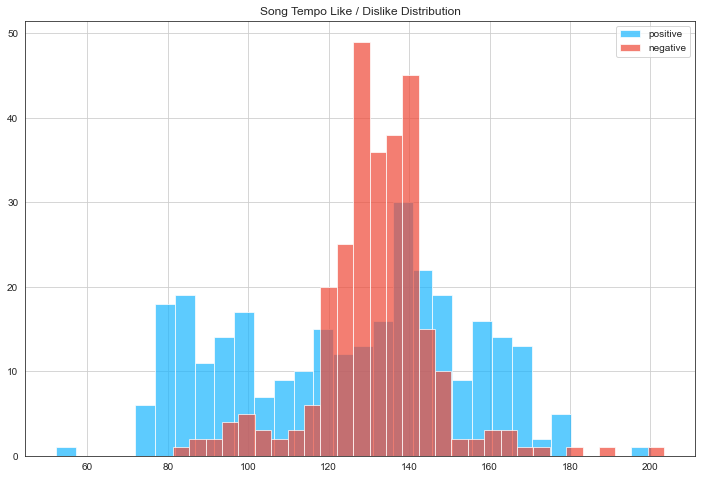

In [17]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_tempo.hist(alpha=0.7, bins=30, label='positive')
neg_tempo.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

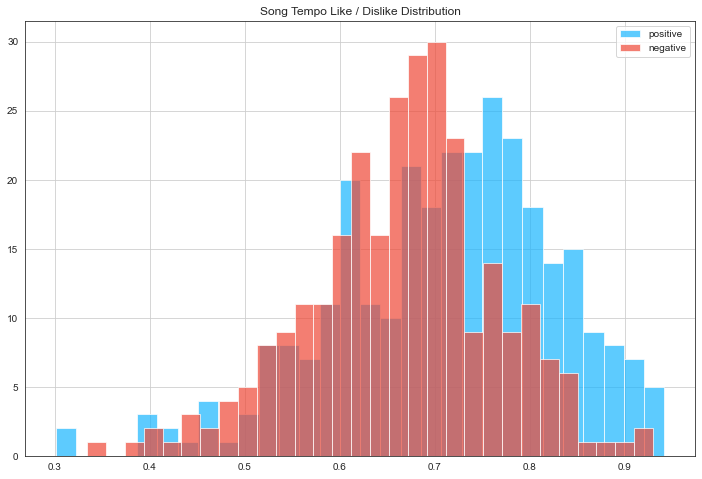

In [18]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_dance.hist(alpha=0.7, bins=30, label='positive')
neg_dance.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

<AxesSubplot: >

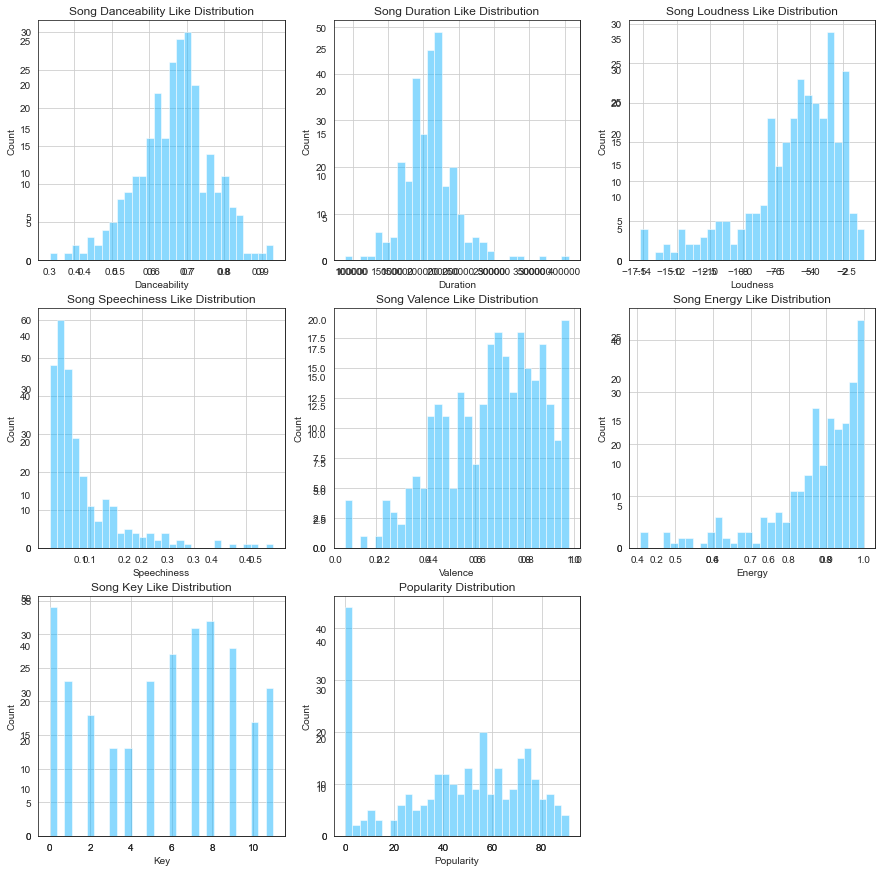

In [24]:
fig2 = plt.figure(figsize=(15,15))

#Danceability
ax3 = fig2.add_subplot(331)
ax3.set_xlabel('Danceability')
ax3.set_ylabel('Count')
ax3.set_title('Song Danceability Like Distribution')
pos_dance.hist(alpha= 0.5, bins=30)
ax4 = fig2.add_subplot(331)
neg_dance.hist(alpha= 0.5, bins=30)

#Duration_ms
ax5 = fig2.add_subplot(332)
ax5.set_xlabel('Duration')
ax5.set_ylabel('Count')
ax5.set_title('Song Duration Like Distribution')
pos_duration.hist(alpha= 0.5, bins=30)
ax6 = fig2.add_subplot(332)
neg_duration.hist(alpha= 0.5, bins=30)

#Loudness
ax7 = fig2.add_subplot(333)
ax7.set_xlabel('Loudness')
ax7.set_ylabel('Count')
ax7.set_title('Song Loudness Like Distribution')
pos_loudness.hist(alpha= 0.5, bins=30)
ax8 = fig2.add_subplot(333)
neg_loudness.hist(alpha= 0.5, bins=30)

#Speechiness
ax9 = fig2.add_subplot(334)
ax9.set_xlabel('Speechiness')
ax9.set_ylabel('Count')
ax9.set_title('Song Speechiness Like Distribution')
pos_speechiness.hist(alpha= 0.5, bins=30)
ax10 = fig2.add_subplot(334)
neg_speechiness.hist(alpha= 0.5, bins=30)

#Valence
ax11 = fig2.add_subplot(335)
ax11.set_xlabel('Valence')
ax11.set_ylabel('Count')
ax11.set_title('Song Valence Like Distribution')
pos_valence.hist(alpha= 0.5, bins=30)
ax12 = fig2.add_subplot(335)
neg_valence.hist(alpha= 0.5, bins=30)

#Energy
ax13 = fig2.add_subplot(336)
ax13.set_xlabel('Energy')
ax13.set_ylabel('Count')
ax13.set_title('Song Energy Like Distribution')
pos_energy.hist(alpha= 0.5, bins=30)
ax14 = fig2.add_subplot(336)
neg_energy.hist(alpha= 0.5, bins=30)

#Key
ax15 = fig2.add_subplot(337)
ax15.set_xlabel('Key')
ax15.set_ylabel('Count')
ax15.set_title('Song Key Like Distribution')
pos_key.hist(alpha= 0.5, bins=30)
ax16 = fig2.add_subplot(337)
neg_key.hist(alpha= 0.5, bins=30)

#Key
ax15 = fig2.add_subplot(338)
ax15.set_xlabel('Popularity')
ax15.set_ylabel('Count')
ax15.set_title('Popularity Distribution')
pos_popularity.hist(alpha= 0.5, bins=30)
ax16 = fig2.add_subplot(338)
neg_popularity.hist(alpha= 0.5, bins=30)


In [25]:
#Define the set of features that we want to look at
features = ["danceability", "loudness", "valence", "energy", "instrumentalness", "acousticness", "key", "speechiness","duration_ms"]

In [26]:
#Split the data into x and y test and train sets to feed them into a bunch of classifiers!
x_train = train[features]
y_train = train["target"]

x_test = test[features]
y_test = test["target"]

In [27]:
c = DecisionTreeClassifier(min_samples_split=100)
dt = c.fit(x_train, y_train)

In [28]:
def show_tree(InputTree, features, path):
    f = io.StringIO()
    tree.export_graphviz(InputTree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = misc.imread(path)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.imshow(img)
show_tree(dt, features, "dec_tree.png")

InvocationException: GraphViz's executables not found

In [29]:
y_pred = c.predict(x_test)
score = accuracy_score(y_test, y_pred) * 100
print("Accuracy using Decision Tree: ", round(score, 1), "%")

Accuracy using Decision Tree:  88.5 %


In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3)
knn.fit(x_train, y_train)
knn_pred = c.predict(x_test)
score = accuracy_score(y_test, knn_pred) * 100
print("Accuracy using Knn Tree: ", round(score, 1), "%")

Accuracy using Knn Tree:  88.5 %


In [31]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
mlp_pred = mlp.predict(x_test)
score = accuracy_score(y_test, mlp_pred) * 100
print("Accuracy using mlp Tree: ", round(score, 1), "%")

Accuracy using mlp Tree:  35.6 %


In [32]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
forest.fit(x_train, y_train)
forest_pred = forest.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, forest_pred) * 100
print("Accuracy using random forest: ", round(score, 1), "%")

Accuracy using random forest:  90.8 %


In [33]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(x_train, y_train)
ada_pred = ada.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, ada_pred) * 100
print("Accuracy using ada: ", round(score, 1), "%")

Accuracy using ada:  92.0 %


c:\Users\dev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [34]:
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
gauss.fit(x_train, y_train)
gauss_pred = gauss.predict(x_test)
score = accuracy_score(y_test, gauss_pred)*100
print("Accuracy using gauss: ", round(score, 1), "%")

Accuracy using gauss:  69.0 %


In [35]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0)
k_means.fit(x_train, y_train)
predicted= k_means.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Kmeans: ", round(score, 1), "%")

Accuracy using Kmeans:  36.8 %


In [36]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, max_depth=1, random_state=0)
gbc.fit(x_train, y_train)
predicted = gbc.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Gbc: ", round(score, 1), "%")

Accuracy using Gbc:  92.0 %
